In [1]:
from pygsp import graphs, filters
import pyunlocbox
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

In [3]:
adjacency_matrix = np.load("processed_data/coexpression_adjacency.npy")
node_indices = np.load("processed_data/coexpression_node_indices.npy")
expression_data = pd.read_pickle("processed_data/expression_data.pkl")
selected_features = pd.read_pickle("processed_data/selected_features.pkl")

We use the coexpression graph with signal set to SNP expression with missing values set to mean. For each mouse we apply Tikhonov regularization for imputation.

In [4]:
G = graphs.Graph(adjacency_matrix)
G.set_coordinates()

In [5]:
mice_with_susceptibility = selected_features.index.tolist()
expression_with_susceptibility = expression_data.iloc[node_indices].T

In [6]:
na_df = expression_with_susceptibility.isna()

In [7]:
expression_with_susceptibility.fillna(0, inplace=True)

We draw a graph to make sure that there is certain smoothness present - this validates our method of constructing graph and justifies using Tikhonov regularization.

We can see groups of darker and groups of brighter nodes, which shows that indeed some of the SNPs close according to our distance coexpress.

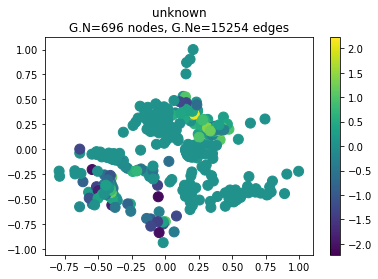

In [8]:
label_signal = expression_with_susceptibility.values[50, :]
fig = G.plot_signal(label_signal)

In [9]:
L = G.D.toarray()
r = pyunlocbox.functions.norm_l2(A=L, tight=False)

def tikhonov_regularize(label_signal, gamma=1):
    step = 0.999 / np.linalg.norm(np.dot(L.T, L) + gamma, 2)
    solver = pyunlocbox.solvers.gradient_descent(step=step)
    x0 = label_signal.copy()
    f = pyunlocbox.functions.norm_l2(y=label_signal,
                                      lambda_=gamma)
    prob2 = pyunlocbox.solvers.solve([r, f], solver=solver,
                                         x0=x0, rtol=0, maxit=1000)
    return prob2["sol"]

2020-01-09 19:18:21,164:[WARNING](pygsp.graphs.graph.D): The differential operator G.D is not available, we need to compute it. Explicitly call G.compute_differential_operator() once beforehand to suppress the warning.


We tune the parameters, especially gamma, to have some of the missing expression values updated considerably (by at least 0.5 where $\sigma=1$) and at the same time to keep the error for the known values small.

Solution found after 1000 iterations:
    objective function f(sol) = 4.235272e+01
    stopping criterion: MAXIT


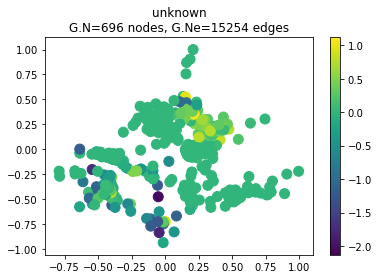

In [10]:
label_signal = expression_with_susceptibility.values[50, :]
solution = tikhonov_regularize(label_signal)
G.plot_signal(solution)

Maximal value of the inferred expression:

In [11]:
max(abs(solution[na_df.values[50]]))

0.19437407281117763

Average error per node:

In [12]:
error = (abs(label_signal[~na_df.values[50]] - solution[~na_df.values[50]])).sum()
number_of_known = (~na_df.values[50]).sum()
error/number_of_known

0.2713583155728545

We iterate for all mice to perform imputation.

In [13]:
import time
gamma = 1
inferred = np.zeros_like(expression_with_susceptibility.values)
start_time = time.time()

for mouse_id in range(inferred.shape[0]):
    label_signal = expression_with_susceptibility.values[mouse_id, :]
    solution = tikhonov_regularize(label_signal)
    inferred[mouse_id] = solution

    time_elapsed = time.time() - start_time
    time_total = inferred.shape[0]/(mouse_id + 1) * time_elapsed
    print(f"{mouse_id + 1} mouse. {time_elapsed/60}m/{time_total/60}m")

np.save(f"processed_data/inferred_{gamma}.npy", inferred)

Solution found after 1000 iterations:
    objective function f(sol) = 6.911855e+01
    stopping criterion: MAXIT
1 mouse. 0.1610111673672994m/13.846960393587748m
Solution found after 1000 iterations:
    objective function f(sol) = 1.779687e+02
    stopping criterion: MAXIT
2 mouse. 0.3083946148554484m/13.260968438784282m
Solution found after 1000 iterations:
    objective function f(sol) = 2.581915e+01
    stopping criterion: MAXIT
3 mouse. 0.4390927990277608m/12.587326905462477m
Solution found after 1000 iterations:
    objective function f(sol) = 5.484651e+01
    stopping criterion: MAXIT
4 mouse. 0.5732880155245463m/12.325692333777745m
Solution found after 1000 iterations:
    objective function f(sol) = 2.930310e+01
    stopping criterion: MAXIT
5 mouse. 0.7044067144393921m/12.115795488357543m
Solution found after 1000 iterations:
    objective function f(sol) = 2.240649e+02
    stopping criterion: MAXIT
6 mouse. 0.8372714996337891m/12.000891494750977m
Solution found after 1000 it

In [14]:
inferred = np.load(f"processed_data/inferred_{gamma}.npy")
# we scale the inferred expression values to have standard deviation 1, like the original data
for col in range(inferred.shape[1]):
    inferred[:, col] = inferred[:, col] * 9 # we scale the inferred features to have larger magnitude
# fill in missing values
expression_full = pd.read_pickle("processed_data/expression_data.pkl")
expression_full = expression_full.iloc[node_indices].T
expression_full.values[na_df] = inferred[na_df]

In [15]:
malaria_susceptibility = pd.read_pickle("processed_data/malaria_susceptibility.pkl")

In [16]:
not_inferred = [i for i in range(400) if i not in node_indices]

In [17]:
expression_full_susceptibility = pd.DataFrame(malaria_susceptibility.iloc[:,-1]).join(expression_full)\
                                                                                .join(selected_features.iloc[:,not_inferred]).fillna(0)

In [18]:
X_train, y_train = expression_full_susceptibility.iloc[:,1:], expression_full_susceptibility.iloc[:,0]

In [19]:
from sklearn.linear_model import RidgeCV
def evaluate_ridge(X_train_eval, y_eval, upper_alpha_limit=80):
    alphas=np.linspace(1e-10, upper_alpha_limit, 50)
    clf_ridge_relevant = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train_eval, y_eval)
    best_alpha_index = np.where(alphas == clf_ridge_relevant.alpha_)[0]
    print(f"best alpha: {clf_ridge_relevant.alpha_}")
    print(f"mean error: {clf_ridge_relevant.cv_values_[:,best_alpha_index].mean()}")
    return clf_ridge_relevant

In [20]:
clf_inferred = evaluate_ridge(X_train, y_train)

best alpha: 65.30612244899797
mean error: 0.02269467248121717


In [21]:
pd_orig = pd.DataFrame(malaria_susceptibility.iloc[:,-1]).join(selected_features)
X_train_m, y_train_m = pd_orig.iloc[:,1:], pd_orig.iloc[:,0]
evaluate_ridge(X_train_m.fillna(0), y_train_m);

best alpha: 70.20408163266531
mean error: 0.02445208879622456


We see that using inferred expression values outperforms the model using mean expression in place of the missing values, so the expression graph proved useful.

In [22]:
pd.to_pickle(expression_full_susceptibility, "processed_data/expression_full_susceptibility.pkl")